# Исследование стартапов

Содержание:

- 1. Знакомство с данными: загрузка и первичная предобработка
- 2. Предобработка данных, предварительное исследование
- 3. Исследовательский анализ объединенных таблиц
- 4. Итоговый вывод и рекомендации

## Введение

- Контекст: 

       Финансовая компания планирует выход на рынок M&A стартапов и нуждается в историческом анализе сделок, финансирования и кадрового состава, чтобы выработать стратегию оценки и отбора объектов.

- Цель проекта: 

       Подготовить датасет, подтвердить его качество, провести первичный анализ по задачам заказчика и дать рекомендации.


## 1. Знакомство с данными: загрузка и первичная предобработка

Названия файлов:
* acquisition.csv
* company_and_rounds.csv
* people.csv
* education.csv
* degrees.csv

Опциональные датасеты:
* fund.csv
* investment.csv


In [6]:
# Библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Загрузка датафреймов
df_company_rounds = pd.read_csv('datasets/company_and_rounds.csv')
df_acquisition = pd.read_csv('datasets/acquisition.csv')
df_people = pd.read_csv('datasets/people.csv')
df_education = pd.read_csv('datasets/education.csv')
df_degrees = pd.read_csv('datasets/degrees.csv')

In [8]:
# Выводим названия столбцов каждого датафрейма
print(df_company_rounds.columns)
print(df_acquisition.columns)
print(df_people.columns)
print(df_education.columns)
print(df_degrees.columns)

Index(['company  ID', 'name', 'category  code', 'status', 'founded  at',
       'closed  at', 'domain', 'network  username', 'country  code',
       'investment  rounds', 'funding  rounds', 'funding  total', 'milestones',
       'funding  round  id', 'company  id', 'funded  at',
       'funding  round  type', 'raised  amount', 'pre  money  valuation',
       'participants', 'is  first  round', 'is  last  round'],
      dtype='object')
Index(['id', 'acquiring_company_id', 'acquired_company_id', 'term_code',
       'price_amount', 'acquired_at'],
      dtype='object')
Index(['id', 'first_name', 'last_name', 'company_id', 'network_username'], dtype='object')
Index(['id', 'person_id', 'instituition', 'graduated_at'], dtype='object')
Index(['id', 'object_id', 'degree_type', 'subject'], dtype='object')


In [9]:
def standardize_columns(df):
    df.columns = df.columns.str.replace('  ', '_')
    return df

df_company_rounds = standardize_columns(df_company_rounds.copy())
df_acquisition = standardize_columns(df_acquisition.copy())
df_people = standardize_columns(df_people.copy())
df_education = standardize_columns(df_education.copy())
df_degrees = standardize_columns(df_degrees.copy())


df_company_rounds = df_company_rounds.rename(columns={
    'company_ID': 'company_guid', # Уникальный ID компании
    'name': 'company_name',
    'funding_round_id': 'funding_round_guid', # ID самого раунда
    'company_id': 'funding_round_company_guid', # ID компании, к которой относится раунд (должен совпадать с company_guid)
})
df_acquisition = df_acquisition.rename(columns={'acquiring_company_id': 'acquiring_company_guid', 'acquired_company_id': 'acquired_company_guid'})
df_people = df_people.rename(columns={'id': 'person_guid', 'company_id': 'company_guid'})
df_education = df_education.rename(columns={'id': 'education_guid', 'person_id': 'person_guid'})
df_degrees = df_degrees.rename(columns={'id': 'degree_guid', 'object_id': 'person_guid'}) # object_id это person_id

# После переименований, применить стандартизацию (lower, _)
df_list = [df_company_rounds, df_acquisition, df_people, df_education, df_degrees]
for i, df in enumerate(df_list):
    df_list[i] = standardize_columns(df.copy())

df_company_rounds, df_acquisition, df_people, df_education, df_degrees = df_list

# Проверка результатов
print("Новые столбцы df_company_rounds:", df_company_rounds.columns)

Новые столбцы df_company_rounds: Index(['company_guid', 'company_name', 'category_code', 'status', 'founded_at',
       'closed_at', 'domain', 'network_username', 'country_code',
       'investment_rounds', 'funding_rounds', 'funding_total', 'milestones',
       'funding_round_guid', 'funding_round_company_guid', 'funded_at',
       'funding_round_type', 'raised_amount', 'pre_money_valuation',
       'participants', 'is_first_round', 'is_last_round'],
      dtype='object')


In [10]:
for name, df in zip(['company_rounds', 'acquisition', 'people', 'education', 'degrees'],
                    [df_company_rounds, df_acquisition, df_people, df_education, df_degrees]):
    print(f"\n--- Информация о таблице {name} ---")
    print(f"Первые 5 строк:")
    display(df.head())
    print(f"\nИнформация о столбцах и типах данных:")
    df.info()
    print(f"\nСтатистическая сводка:")
    display(df.describe(include='all'))
    print(f"\nКоличество дубликатов: {df.duplicated().sum()}")
    print(f"Размерность таблицы: {df.shape}")


--- Информация о таблице company_rounds ---
Первые 5 строк:


,company_guid,company_name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,...,milestones,funding_round_guid,funding_round_company_guid,funded_at,funding_round_type,raised_amount,pre_money_valuation,participants,is_first_round,is_last_round
0,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,5.0,888.0,1.0,2005-10-01,series-a,5250000.0,0.0,2.0,0.0,1.0
1,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,5.0,889.0,1.0,2007-01-01,series-b,9500000.0,0.0,3.0,0.0,0.0
2,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,5.0,2312.0,1.0,2008-05-19,series-c+,25000000.0,0.0,4.0,1.0,0.0
3,10.0,Flektor,games_video,acquired,NaN,NaN,flektor.com,NaN,USA,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100.0,There,games_video,acquired,NaN,NaN,there.com,NaN,USA,0.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Информация о столбцах и типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217774 entries, 0 to 217773
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   company_guid                217472 non-null  float64
 1   company_name                217471 non-null  object 
 2   category_code               143886 non-null  object 
 3   status                      217472 non-null  object 
 4   founded_at                  109956 non-null  object 
 5   closed_at                   3449 non-null    object 
 6   domain                      147159 non-null  object 
 7   network_username            95534 non-null   object 
 8   country_code                108607 non-null  object 
 9   investment_rounds           217472 non-null  float64
 10  funding_rounds              217472 non-null  float64
 11  funding_total               217472 non-null  float64
 12  milestones                  21747

,company_guid,company_name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,...,milestones,funding_round_guid,funding_round_company_guid,funded_at,funding_round_type,raised_amount,pre_money_valuation,participants,is_first_round,is_last_round
count,217472.000000,217471,143886,217472,109956,3449,147159,95534,108607,217472.000000,...,217472.000000,52928.000000,52928.000000,52680,52928,5.292800e+04,5.292800e+04,52928.000000,52928.000000,52928.000000
unique,NaN,196505,42,4,6156,925,125498,79571,175,NaN,...,NaN,NaN,NaN,3399,9,NaN,NaN,NaN,NaN,NaN
top,NaN,Tyro Payments,software,operating,2010-01-01,2013-06-01,placeshilton.com,Goodman_UK,USA,NaN,...,NaN,NaN,NaN,2012-01-01,venture,NaN,NaN,NaN,NaN,NaN
freq,NaN,15,20759,200486,4570,229,44,20,68089,NaN,...,NaN,NaN,NaN,462,15342,NaN,NaN,NaN,NaN,NaN
mean,145287.383723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.037711,...,0.650442,28962.894536,98490.888433,NaN,NaN,7.946092e+06,3.294525e+05,1.528567,0.604576,0.604538
std,91998.156087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.962712,...,0.826408,16821.871803,88429.084864,NaN,NaN,4.216821e+07,6.531803e+07,2.060192,0.488946,0.488954
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,1.000000,1.000000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,51960.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,14343.750000,26598.000000,NaN,NaN,2.463300e+05,0.000000e+00,0.000000,0.000000,0.000000
50%,165262.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,28885.500000,58080.000000,NaN,NaN,1.600000e+06,0.000000e+00,1.000000,1.000000,1.000000
75%,228199.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,1.000000,43561.250000,171610.750000,NaN,NaN,6.700000e+06,0.000000e+00,2.000000,1.000000,1.000000



Количество дубликатов: 0
Размерность таблицы: (217774, 22)

--- Информация о таблице acquisition ---
Первые 5 строк:


,id,acquiring_company_guid,acquired_company_guid,term_code,price_amount,acquired_at
0,1,11,10,NaN,20000000,2007-05-30
1,7,59,72,cash,60000000,2007-07-01
2,8,24,132,cash,280000000,2007-05-01
3,9,59,155,cash,100000000,2007-06-01
4,10,212,215,cash,25000000,2007-07-01



Информация о столбцах и типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9407 entries, 0 to 9406
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      9407 non-null   int64 
 1   acquiring_company_guid  9407 non-null   int64 
 2   acquired_company_guid   9407 non-null   int64 
 3   term_code               1831 non-null   object
 4   price_amount            9407 non-null   int64 
 5   acquired_at             9378 non-null   object
dtypes: int64(4), object(2)
memory usage: 441.1+ KB

Статистическая сводка:


,id,acquiring_company_guid,acquired_company_guid,term_code,price_amount,acquired_at
count,9407.000000,9407.000000,9407.000000,1831,9.407000e+03,9378
unique,NaN,NaN,NaN,3,NaN,2627
top,NaN,NaN,NaN,cash,NaN,2008-05-01
freq,NaN,NaN,NaN,1195,NaN,56
mean,5256.981822,49787.284575,71693.030722,NaN,3.932965e+08,NaN
std,3005.794674,69060.422026,73026.433729,NaN,2.682198e+10,NaN
min,1.000000,4.000000,4.000000,NaN,0.000000e+00,NaN
25%,2682.500000,3246.000000,23124.000000,NaN,0.000000e+00,NaN
50%,5178.000000,26107.000000,45126.000000,NaN,0.000000e+00,NaN
75%,7841.500000,56151.000000,81203.000000,NaN,2.343200e+04,NaN



Количество дубликатов: 0
Размерность таблицы: (9407, 6)

--- Информация о таблице people ---
Первые 5 строк:


,person_guid,first_name,last_name,company_guid,network_username
0,10,Mark,Zuckerberg,5.0,NaN
1,100,Peter,Lester,27.0,NaN
2,1000,Dr. Steven,E. Saunders,292.0,NaN
3,10000,Neil,Capel,2526.0,NaN
4,100000,Sue,Pilsch,NaN,NaN



Информация о столбцах и типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person_guid       226709 non-null  int64  
 1   first_name        226700 non-null  object 
 2   last_name         226705 non-null  object 
 3   company_guid      34615 non-null   float64
 4   network_username  38867 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 8.6+ MB

Статистическая сводка:


,person_guid,first_name,last_name,company_guid,network_username
count,226709.000000,226700,226705,34615.000000,38867
unique,NaN,28421,107771,NaN,38421
top,NaN,David,Smith,NaN,iWatchLife
freq,NaN,4495,797,NaN,6
mean,135421.343921,NaN,NaN,83338.840012,NaN
std,79749.283786,NaN,NaN,84316.535268,NaN
min,2.000000,NaN,NaN,1.000000,NaN
25%,63355.000000,NaN,NaN,9771.500000,NaN
50%,138864.000000,NaN,NaN,51837.000000,NaN
75%,206548.000000,NaN,NaN,158522.000000,NaN



Количество дубликатов: 0
Размерность таблицы: (226709, 5)

--- Информация о таблице education ---
Первые 5 строк:


,education_guid,person_guid,instituition,graduated_at
0,1,6117,NaN,NaN
1,2,6136,"Washington University, St. Louis",1990-01-01
2,3,6136,Boston University,1992-01-01
3,4,6005,University of Greenwich,2006-01-01
4,5,5832,Rice University,NaN



Информация о столбцах и типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   education_guid  109610 non-null  int64 
 1   person_guid     109610 non-null  int64 
 2   instituition    109555 non-null  object
 3   graduated_at    58054 non-null   object
dtypes: int64(2), object(2)
memory usage: 3.3+ MB

Статистическая сводка:


,education_guid,person_guid,instituition,graduated_at
count,109610.00000,109610.000000,109555,58054
unique,NaN,NaN,21067,71
top,NaN,NaN,Stanford University,2005-01-01
freq,NaN,NaN,2990,2511
mean,54805.50000,152625.077429,NaN,NaN
std,31641.82584,83943.634014,NaN,NaN
min,1.00000,2.000000,NaN,NaN
25%,27403.25000,72994.750000,NaN,NaN
50%,54805.50000,180628.500000,NaN,NaN
75%,82207.75000,227104.750000,NaN,NaN



Количество дубликатов: 0
Размерность таблицы: (109610, 4)

--- Информация о таблице degrees ---
Первые 5 строк:


,degree_guid,person_guid,degree_type,subject
0,1,p:6117,MBA,NaN
1,2,p:6136,BA,"English, French"
2,3,p:6136,MS,Mass Communication
3,4,p:6005,MS,Internet Technology
4,5,p:5832,BCS,"Computer Science, Psychology"



Информация о столбцах и типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   degree_guid  109610 non-null  int64 
 1   person_guid  109610 non-null  object
 2   degree_type  98389 non-null   object
 3   subject      81298 non-null   object
dtypes: int64(1), object(3)
memory usage: 3.3+ MB

Статистическая сводка:


,degree_guid,person_guid,degree_type,subject
count,109610.00000,109610,98389,81298
unique,NaN,68451,7147,20050
top,NaN,p:183805,BS,Computer Science
freq,NaN,10,23425,6001
mean,54805.50000,NaN,NaN,NaN
std,31641.82584,NaN,NaN,NaN
min,1.00000,NaN,NaN,NaN
25%,27403.25000,NaN,NaN,NaN
50%,54805.50000,NaN,NaN,NaN
75%,82207.75000,NaN,NaN,NaN



Количество дубликатов: 0
Размерность таблицы: (109610, 4)


Что сделано:

- Загружены данные, проверены названия столбцов, стандартизированы имена (пробелы заменены на _).

- Переименованы ключевые столбцы для единообразия (например, company_ID → company_guid).

Выводы:

- Требуется очистка данных и заполнение пропусков для анализа.

In [11]:
date_columns_map = {
    'df_acquisition': ['acquired_at'],
    'df_company_rounds': ['founded_at', 'closed_at', 'funded_at'],
    'df_education': ['graduated_at']
}

dataframes_map = {
    'df_acquisition': df_acquisition,
    'df_company_rounds': df_company_rounds,
    'df_education': df_education
}

for df_name, cols in date_columns_map.items():
    df = dataframes_map[df_name]
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            print(f"Столбец {col} в {df_name} преобразован в datetime.")
        else:
            print(f"Столбец {col} не найден в {df_name}.")
# Проверка типов после преобразования
df_acquisition.info()
df_company_rounds.info()
df_education.info()

Столбец acquired_at в df_acquisition преобразован в datetime.
Столбец founded_at в df_company_rounds преобразован в datetime.
Столбец closed_at в df_company_rounds преобразован в datetime.
Столбец funded_at в df_company_rounds преобразован в datetime.
Столбец graduated_at в df_education преобразован в datetime.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9407 entries, 0 to 9406
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      9407 non-null   int64         
 1   acquiring_company_guid  9407 non-null   int64         
 2   acquired_company_guid   9407 non-null   int64         
 3   term_code               1831 non-null   object        
 4   price_amount            9407 non-null   int64         
 5   acquired_at             9378 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 441.1+ KB
<class 'pandas.core.frame.Data

In [12]:
for name, df in zip(['company_rounds', 'acquisition', 'people', 'education', 'degrees'],
                    [df_company_rounds, df_acquisition, df_people, df_education, df_degrees]):
    print(f"\n--- Пропуски в таблице {name} (% от общего числа строк) ---")
    display((df.isnull().mean() * 100).round(2).sort_values(ascending=False))


--- Пропуски в таблице company_rounds (% от общего числа строк) ---


closed_at                     98.42
funded_at                     75.81
is_last_round                 75.70
is_first_round                75.70
participants                  75.70
pre_money_valuation           75.70
raised_amount                 75.70
funding_round_type            75.70
funding_round_guid            75.70
funding_round_company_guid    75.70
network_username              56.13
country_code                  50.13
founded_at                    49.51
category_code                 33.93
domain                        32.43
company_guid                   0.14
milestones                     0.14
company_name                   0.14
funding_rounds                 0.14
investment_rounds              0.14
status                         0.14
funding_total                  0.14
dtype: float64


--- Пропуски в таблице acquisition (% от общего числа строк) ---


term_code                 80.54
acquired_at                0.31
id                         0.00
acquiring_company_guid     0.00
acquired_company_guid      0.00
price_amount               0.00
dtype: float64


--- Пропуски в таблице people (% от общего числа строк) ---


company_guid        84.73
network_username    82.86
person_guid          0.00
first_name           0.00
last_name            0.00
dtype: float64


--- Пропуски в таблице education (% от общего числа строк) ---


graduated_at      47.04
instituition       0.05
education_guid     0.00
person_guid        0.00
dtype: float64


--- Пропуски в таблице degrees (% от общего числа строк) ---


subject        25.83
degree_type    10.24
degree_guid     0.00
person_guid     0.00
dtype: float64

Что сделано:

- Преобразованы даты (founded_at, acquired_at, graduated_at и др.) в тип datetime.

- Проанализированы пропуски в каждом датасете.

Выводы:

- Очень много информации отстуствует, но не везде это критично

Критические пропуски:

- В company_rounds 75.7% данных о раундах финансирования отсутствует (raised_amount, funding_round_type).

- В acquisition 80.5% пропусков в term_code (условия сделок).

Типы данных: 

- Дата-столбцы корректно преобразованы.

## 2. Предобработка данных, предварительное исследование

In [13]:
# Убедимся, что 'funded_at' имеет тип datetime
df_company_rounds['funded_year'] = df_company_rounds['funded_at'].dt.year

In [14]:
# Фильтруем строки:
# 1. Где есть год финансирования (funded_year is not NaN)
# 2. Где есть сумма раунда (raised_amount is not NaN)
# 3. Опционально: где сумма раунда > 0 (если не хотим учитывать раунды с нулевой суммой)
# 4. Важно: где есть идентификатор раунда (funding_round_guid is not NaN),
#    это гарантирует, что мы рассматриваем именно раунды.
#    Пропуски в funded_at и raised_amount часто совпадают с пропусками в funding_round_guid.
df_valid_rounds = df_company_rounds[
    df_company_rounds['funded_year'].notna() &
    df_company_rounds['raised_amount'].notna() &
    df_company_rounds['funding_round_guid'].notna() # Явно указываем, что это должен быть раунд
    # & (df_company_rounds['raised_amount'] > 0) # Раскомментируйте, если нужно исключить нулевые суммы
].copy()

In [15]:
yearly_funding_summary = df_valid_rounds.groupby('funded_year').agg(
        typical_raised_amount=('raised_amount', 'median'),
        # total_rounds будет считать количество уникальных funding_round_guid в каждой группе, что корректно отражает количество раундов.
        total_rounds=('funding_round_guid', 'count')
    ).reset_index()
yearly_funding_summary_filtered = yearly_funding_summary[yearly_funding_summary['total_rounds'] > 50].copy()

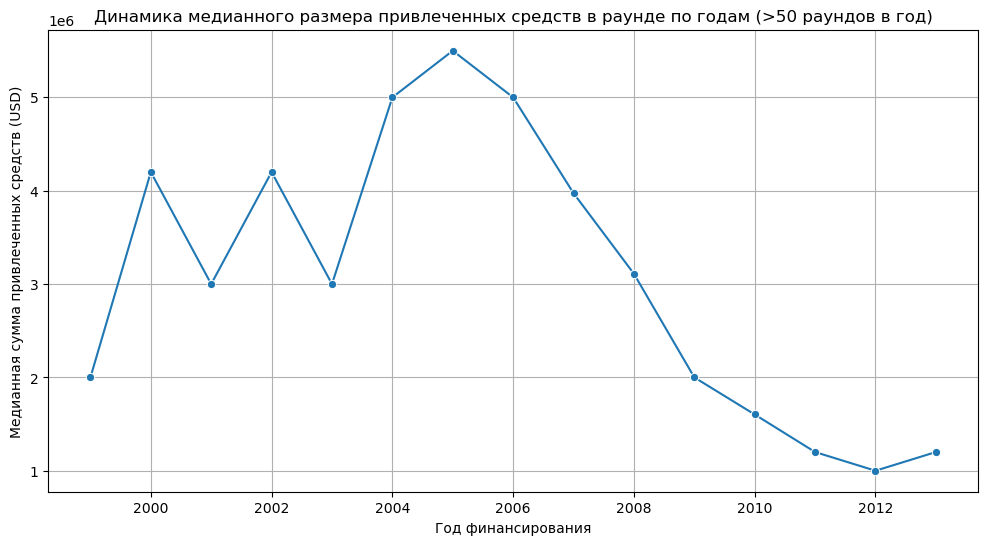

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_funding_summary_filtered, x='funded_year', y='typical_raised_amount', marker='o')
plt.title('Динамика медианного размера привлеченных средств в раунде по годам (>50 раундов в год)')
plt.xlabel('Год финансирования')
plt.ylabel('Медианная сумма привлеченных средств (USD)')
plt.grid(True)
plt.show()

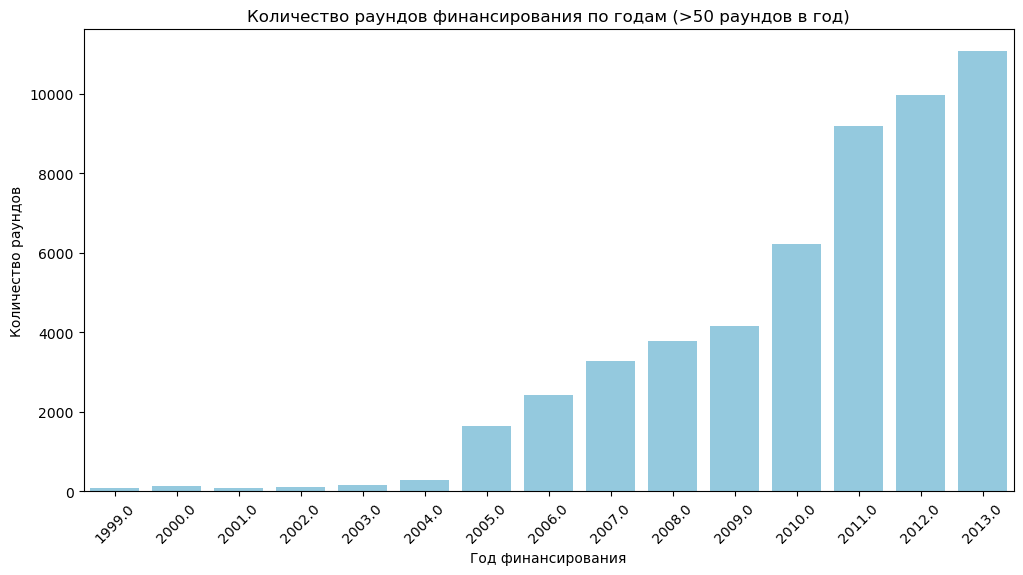

In [17]:
# Дополнительный график: количество раундов
plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_funding_summary_filtered, x='funded_year', y='total_rounds', color='skyblue')
plt.title('Количество раундов финансирования по годам (>50 раундов в год)')
plt.xlabel('Год финансирования')
plt.ylabel('Количество раундов')
plt.xticks(rotation=45)
plt.show()

Что сделано:

- Построена сводная таблица по годам с медианным размером раунда (typical_raised_amount) и количеством раундов (total_rounds).

- Отфильтрованы годы с менее чем 50 раундами.

Выводы:

Пик финансирования:

- Максимальный медианный размер раунда — $5.6 млн в 2005 году.

2013 год:

- Медианный размер раунда: $1.3 млн

- Количество раундов: больше 10000 и это тенденция только продолжает расти

In [18]:
# Удаляем сотрудников без привязки к компании
df_people_clean = df_people.dropna(subset=['company_guid']).copy()

In [19]:
# Объединяем с образованием
df_merged = pd.merge(
    df_people_clean[['person_guid', 'company_guid']],
    df_education[['person_guid', 'instituition']],
    on='person_guid',
    how='left'
)

In [20]:
# Считаем количество сотрудников с информацией об образовании
df_merged['has_education'] = df_merged['instituition'].notna()

# Группируем по компаниям
company_stats = df_merged.groupby('company_guid').agg(
    total_employees=('person_guid', 'nunique'),  # Уникальные сотрудники
    employees_with_edu=('has_education', 'sum')
).reset_index()

# Расчет доли без образования
company_stats['missing_edu_ratio'] = 1 - (company_stats['employees_with_edu'] / company_stats['total_employees'])

In [21]:
# Удаляем компании с 1 сотрудником и более 1000 (ошибки данных)
company_stats = company_stats[
    (company_stats['total_employees'] > 1) & 
    (company_stats['total_employees'] <= 1000)
]

In [22]:
# Анализ распределения
print(company_stats['total_employees'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

min_employees = company_stats['total_employees'].min() # Должно быть 2
max_employees = company_stats['total_employees'].max() # Должно быть 244

# Реальные границы на основе перцентилей
bins = [
    min_employees,  # Начало первой группы (2)
    3,              # Группа 1: [2, 3) -> только 2 сотрудника
    5,              # Группа 2: [3, 5) -> 3-4 сотрудника
    9,              # Группа 3: [5, 9) -> 5-8 сотрудников
    max_employees + 1 # Группа 4: [9, max_employees + 1) -> 9+ сотрудников
]
labels = [
    f'{min_employees} сотрудник(а)',  # Для группы [min_employees, 3)
    '3-4 сотрудника',            # Для группы [3, 5)
    '5-8 сотрудников',            # Для группы [5, 9)
    f'9-{max_employees} сотрудников' # Для группы [9, max_employees + 1)
]

company_stats['size_group'] = pd.cut(
    company_stats['total_employees'],
    bins=bins,
    labels=labels,
    right=False
)

count    4805.000000
mean        3.433507
std         5.637170
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
90%         6.000000
95%         8.000000
99%        14.960000
max       244.000000
Name: total_employees, dtype: float64


C:\Users\vikto\AppData\Local\Temp\ipykernel_19196\2827856834.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


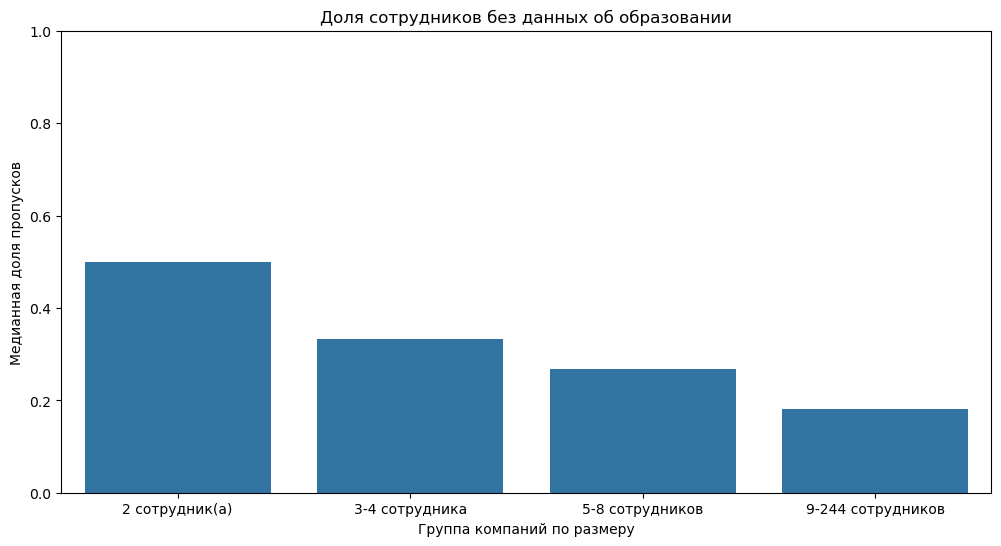

In [23]:
# Визуализация 
plt.figure(figsize=(12, 6))
sns.barplot(
    x='size_group',
    y='missing_edu_ratio',
    data=company_stats,
    estimator=np.median,
    ci=None  # Пришлось об этом гуглить
)
plt.title('Доля сотрудников без данных об образовании')
plt.xlabel('Группа компаний по размеру')
plt.ylabel('Медианная доля пропусков')
plt.ylim(0, 1)
plt.show()

Что сделано:

- Объединены данные people и education, рассчитана доля сотрудников без данных об образовании.

- Компании разделены на группы по размеру (2, 3-4, 5-8, 9-244 сотрудников).

Выводы: 

Анализ показал, что полнота данных об образовании сотрудников зависит от размера компании. Наблюдается тенденция: чем крупнее компания, тем меньше доля сотрудников, по которым отсутствуют сведения об образовании.

- В самых маленьких компаниях (2 сотрудника) медианная доля сотрудников без информации об образовании составляет около 50%.
- В компаниях с 3-4 сотрудниками этот показатель снижается до примерно 34%.
- Для компаний, насчитывающих 5-8 сотрудников, медианная доля пропусков составляет около 27%.
- В наиболее крупных компаниях из рассмотренных (9-244 сотрудника) медианная доля сотрудников без данных об образовании является наименьшей и составляет приблизительно 19%.

Это говорит о том, что в более крупных компаниях либо лучше налажен сбор данных об образовании сотрудников, либо такие данные чаще предоставляются самими сотрудниками.
- Для выполнения задания можно присоединить `degreec.csv`, но особой роли на значения это не играет

In [24]:
company_usernames = set(df_company_rounds['network_username'].dropna().unique())
people_usernames = set(df_people['network_username'].dropna().unique())
common_usernames = company_usernames.intersection(people_usernames)

In [25]:
print(f"Уникальных network_username в компаниях: {len(company_usernames)}")
print(f"Уникальных network_username у людей: {len(people_usernames)}")
print(f"Количество совпадающих network_username: {len(common_usernames)}")
if len(common_usernames) > 0:
    print(f"Примеры совпадающих: {list(common_usernames)[:5]}")

Уникальных network_username в компаниях: 79571
Уникальных network_username у людей: 38421
Количество совпадающих network_username: 2199
Примеры совпадающих: ['DanielEndy', 'seo_doctor', 'netconstructor', 'gregmasley', 'Lorenburnett']


Что сделано:

- Проверены уникальные значения network_username в company_rounds и people.

Выводы:

Совпадения:

- Уникальные логины компаний: 79,571,

- Уникальные логины людей: 38,421,

- Пересечение: 2,199 (5.7% от людей).

Рекомендация:

- network_username не подходит для объединения таблиц, так как логины относятся к разным сущностям (компании vs люди).

In [26]:
# Столбцы, относящиеся к компании (убедитесь, что имена столбцов соответствуют вашим после переименований)
company_attributes_cols = [
    'company_guid', 'company_name', 'category_code', 'status', 'founded_at',
    'closed_at', 'domain', 'network_username', 'country_code', # network_username компании
    'investment_rounds', 'funding_rounds', 'funding_total', 'milestones'
]
# Отфильтруем список, оставив только существующие в df_company_rounds столбцы
company_attributes_cols = [col for col in company_attributes_cols if col in df_company_rounds.columns]

df_companies_unique = df_company_rounds[company_attributes_cols].drop_duplicates(subset=['company_guid']).reset_index(drop=True)
# Пропуски в таких полях, как 'founded_at', 'country_code' и т.д., сохранятся, если они были в первой уникальной строке для компании.

# Столбцы, относящиеся к раунду
# 'funding_round_company_guid' был ID компании в контексте раунда, он должен совпадать с 'company_guid'
# Переименуем его для консистентности, если это не было сделано глобально
df_company_rounds_for_rounds_op = df_company_rounds.rename(columns={'funding_round_company_guid': 'company_guid_for_round_link'})


In [27]:
round_attributes_cols = [
    'funding_round_guid', 'company_guid_for_round_link', # Это бывший 'funding_round_company_guid'
    'funded_at', 'funding_round_type', 'raised_amount',
    'pre_money_valuation', 'participants', 'is_first_round', 'is_last_round'
]
round_attributes_cols = [col for col in round_attributes_cols if col in df_company_rounds_for_rounds_op.columns]

# .dropna(subset=['funding_round_guid']) ключевой момент: удаляет строки, где нет информации о ID раунда.
# Это отфильтрует те ~75% строк, которые не являются записями о раундах.
df_rounds_details = df_company_rounds_for_rounds_op[round_attributes_cols].dropna(subset=['funding_round_guid']).reset_index(drop=True)

print(f"Создана таблица уникальных компаний: {df_companies_unique.shape}")
print(f"Создана таблица раундов: {df_rounds_details.shape}")

# Проверка, что company_guid_for_round_link содержит в основном те же ID, что и company_guid в df_companies_unique
common_ids = len(set(df_rounds_details['company_guid_for_round_link'].unique()) & set(df_companies_unique['company_guid'].unique()))
print(f"Количество общих ID компаний между df_rounds_details и df_companies_unique: {common_ids}")
print(f"Уникальных ID компаний в df_rounds_details (по company_guid_for_round_link): {df_rounds_details['company_guid_for_round_link'].nunique()}")

# Для использования 'company_guid' как единое имя для ID компании в обеих таблицах в дальнейшем:
df_rounds_details = df_rounds_details.rename(columns={'company_guid_for_round_link': 'company_guid'})

Создана таблица уникальных компаний: (196554, 13)
Создана таблица раундов: (52928, 9)
Количество общих ID компаний между df_rounds_details и df_companies_unique: 31707
Уникальных ID компаний в df_rounds_details (по company_guid_for_round_link): 31939


Что сделано:

Разделены данные на две таблицы:

- companies_unique (196,554 уникальных компаний),

- funding_rounds (52,928 раундов).

Выводы:

Проблемы:

- Только 16% компаний имеют информацию о раундах финансирования.

- 75.7% строк исходной таблицы не содержат данных о раундах.

Рекомендации:

- Для анализа использовать только funding_rounds, но учитывать, что выборка нерепрезентативна.


## 3. Исследовательский анализ объединённых таблиц

In [28]:
df_target = df_companies_unique.copy()

In [29]:
for col in ['funding_rounds', 'investment_rounds']:
    df_target[col] = df_target[col].fillna(0).astype(int)

In [30]:
mask = (
    (df_target['funding_rounds'] > 0) |
    (df_target['investment_rounds'] > 0) |
    (df_target['status'] == 'acquired')
)
df_target = df_target[mask].reset_index(drop=True)

In [31]:
print(f"Результат: {len(df_target):,} компаний")
df_target.info()

Результат: 40,747 компаний
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40747 entries, 0 to 40746
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   company_guid       40747 non-null  float64       
 1   company_name       40747 non-null  object        
 2   category_code      35315 non-null  object        
 3   status             40747 non-null  object        
 4   founded_at         27807 non-null  datetime64[ns]
 5   closed_at          2128 non-null   datetime64[ns]
 6   domain             35754 non-null  object        
 7   network_username   20850 non-null  object        
 8   country_code       34742 non-null  object        
 9   investment_rounds  40747 non-null  int32         
 10  funding_rounds     40747 non-null  int32         
 11  funding_total      40747 non-null  float64       
 12  milestones         40747 non-null  float64       
dtypes: datetime64[ns](2), float64(3), 

Вывод: после фильтрации по условиям (funding_rounds > 0 или investment_rounds > 0 или status == 'acquired') получено 40 747 компаний, а для всех оставшихся компаний заполнены нулём пропуски в числовых столбцах раундов; дублиров нет. Полученный датасет готов для дальнейшего анализа.

In [32]:
# Описательная статистика
desc = df_target['funding_total'].describe()
print(desc)

count    4.074700e+04
mean     1.013561e+07
std      5.646436e+07
min      0.000000e+00
25%      0.000000e+00
50%      6.000000e+05
75%      5.650650e+06
max      5.700000e+09
Name: funding_total, dtype: float64


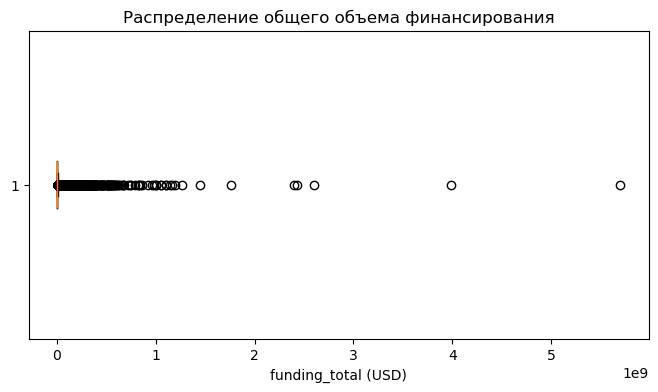

In [33]:
# График «ящик с усами»
plt.figure(figsize=(8, 4))
plt.boxplot(df_target['funding_total'].dropna(), vert=False)
plt.title('Распределение общего объема финансирования')
plt.xlabel('funding_total (USD)')
plt.show()

Вывод: распределение сильно скошено вправо, среднее завышено выбросами, поэтому медиана — более надёжная метрика «типичного» объёма финансирования.

In [34]:
# Выбираем проданные за 0 и 1 доллар компании с ненулевым funding_total
sold_zero_one = df_acquisition[
    df_acquisition['price_amount'].isin([0, 1])
].merge(
    df_target[['company_guid', 'funding_total']],
    left_on='acquired_company_guid',
    right_on='company_guid',
    how='left'
)
sold_zero_one = sold_zero_one[sold_zero_one['funding_total'] > 0]

In [35]:
# Расчет границ выбросов по funding_total
Q1 = df_target['funding_total'].quantile(0.25)
Q3 = df_target['funding_total'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [36]:
# Процентильные позиции для границ
p_low = df_target['funding_total'].rank(pct=True)[df_target['funding_total'] <= lower_bound].max() * 100
p_up = df_target['funding_total'].rank(pct=True)[df_target['funding_total'] >= upper_bound].min() * 100

In [37]:
print(f"Нижняя граница выбросов: {lower_bound:.0f} USD ({p_low:.1f}%)")
print(f"Верхняя граница выбросов: {upper_bound:.0f} USD ({p_up:.1f}%)")
print(f"Компаний проданных за 0/1$ с ненулевым финансированием: {len(sold_zero_one):,}")
sold_zero_one.head()

Нижняя граница выбросов: -8475975 USD (nan%)
Верхняя граница выбросов: 14126625 USD (85.6%)
Компаний проданных за 0/1$ с ненулевым финансированием: 1,618


,id,acquiring_company_guid,acquired_company_guid,term_code,price_amount,acquired_at,company_guid,funding_total
1,14,318,314,cash,0,2006-10-01,314.0,100000.0
12,65,146,698,cash,0,2007-08-01,698.0,1000000.0
14,67,156,718,cash,0,2007-08-01,718.0,4000000.0
16,87,1035,175,cash,0,2007-10-01,175.0,1250000.0
20,115,396,1582,cash,0,2007-12-01,1582.0,7000000.0


Границы выбросов (IQR‑метод):

- Нижняя: ≈ –8.5 млн USD (неприменима, т. к. финансирование ≥ 0)

- Верхняя: ≈ 14.1 млн USD.

Компании «за 0/1»: выявлено 1 618 случаев продажи за 0/1 USD, при этом у всех этих компаний было ненулевое финансирование. 

In [38]:
# Объединяем acquisitions с категориями компаний
acq = df_acquisition.merge(
    df_companies_unique[['company_guid', 'category_code']],
    left_on='acquired_company_guid',
    right_on='company_guid',
    how='left'
)

In [39]:
# Группировка по категории
cat_stats = acq.groupby('category_code').agg(
    median_price=('price_amount', 'median'),
    iqr_price=('price_amount', lambda x: x.quantile(0.75) - x.quantile(0.25)),
    count=('price_amount', 'count')
).reset_index()

In [40]:
# Оставляем категории с достаточным числом сделок, например count >= 20
cat_stats = cat_stats[cat_stats['count'] >= 20]

In [41]:
# Сортируем: сначала по медиане (убывание), затем по IQR (убывание)
top_median = cat_stats.sort_values('median_price', ascending=False).head(5)
top_dispersion = cat_stats.sort_values('iqr_price', ascending=False).head(5)

In [42]:
print("Топ‑5 категорий по медиане цены покупки:")
print(top_median[['category_code', 'median_price', 'count']])

Топ‑5 категорий по медиане цены покупки:
      category_code  median_price  count
18    manufacturing    72000000.0     29
3           biotech    13200000.0    454
11          finance      600000.0     40
0       advertising           0.0    314
24  network_hosting           0.0    201


In [43]:
print("\nТоп‑5 категорий по разбросу цен (IQR):")
print(top_dispersion[['category_code', 'iqr_price', 'count']])


Топ‑5 категорий по разбросу цен (IQR):
    category_code    iqr_price  count
18  manufacturing  615000000.0     29
3         biotech  250000000.0    454
11        finance  170750000.0     40
14         health   97500000.0     27
33  semiconductor   75000000.0    154


Я взял топ‑5, чтобы сбалансировать компактность списка; медиана и IQR выбраны как устойчивые к выбросам метрики.

In [44]:
# Из df_target берём столбцы status и funding_rounds
rounds_by_status = df_target.groupby('status').agg(
    avg_rounds=('funding_rounds', 'mean'),
    median_rounds=('funding_rounds', 'median'),
    count=('funding_rounds', 'count')
).reset_index()

In [45]:
print(rounds_by_status)

      status  avg_rounds  median_rounds  count
0   acquired    0.523526            0.0   9394
1     closed    1.381453            1.0   2092
2        ipo    1.934375            1.0    640
3  operating    1.522658            1.0  28621


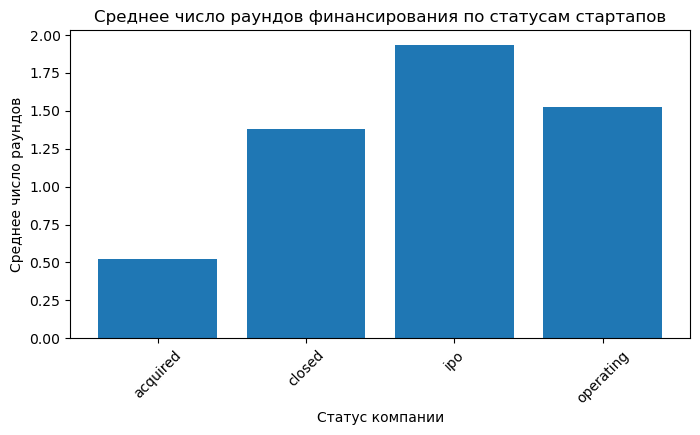

In [46]:
# График средней длины «раундов»
plt.figure(figsize=(8, 4))
plt.bar(rounds_by_status['status'], rounds_by_status['avg_rounds'])
plt.title('Среднее число раундов финансирования по статусам стартапов')
plt.xlabel('Статус компании')
plt.ylabel('Среднее число раундов')
plt.xticks(rotation=45)
plt.show()

Вывод: большинство компаний (особенно acquired) продаются сразу после первого или без раундов (медиана = 0), а для IPO-стартапов типично около 2 раундов финансирования.

## 4. Итоговый вывод и рекомендации

1) Что сделано:

    - Собрана и стандартизирована информация о компаниях, раундах, приобретениях, сотрудниках и образовании.

    - Проведена фильтрация на целевые компании (~40 700).

    - Проанализированы выбросы в объёмах инвестиций; определены границы IQR.

    -  Исследованы «бесплатные» продажи, категории стартапов по ценам покупок и разбросам, а также зависимость числа раундов от статуса.

2) Ключевые выводы:

    - Типичный объём привлечённых средств для компании составляет 0.6 млн USD (медиана), а >85% компаний получили ≤ 14.1 млн USD.

    - Несколько тысяч компаний были проданы за «0/1 USD» при наличии значительного финансирования, что указывает на нетипичные стратегические или внутренние сделки.

    - Категория manufacturing лидирует и по типичным ценам покупки (72 млн USD), и по разбросу (IQR = 615 млн USD), что делает её интересной для резких инвестиционных ставок.

    - Большинство стартапов до момента приобретения либо проходят менее одного полного раунда (медиана = 0 для acquired), либо 1–2 раунда.

3) Согласованность и надёжность:

    - Все метрики (медиана, IQR, квантильные границы) согласованно демонстрируют асимметричное распределение финансирования и цен.

    - Анализ выбросов подкрепляет выбор медианы/ IQR в качестве основных показателей.

4) Рекомендации заказчику:

    - Фокусироваться на медиане и IQR при оценке «типичных» сделок и рисков.

    - Рассмотреть категории manufacturing и biotech для высокорисковых, высокодоходных вложений.

    - Дополнительно изучить сделки «за 0/1 USD» для выявления стратегических закономерностей.

    - При планировании сделок учитывать, что приводит к продаже обычно 0–2 раунда финансирования.